### Connection  to Drive and Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/UNIVERSITA/ANN/ANNDL/Homework1



In [1]:
from function_folder.librarys import *

librerie in caricamento
2.13.0
librerie caricate


## Ricaricare i moduli

importlib.reload(nome_modulo)

### Load and process the dataset

(5200, 96, 96, 3)
(5200,)


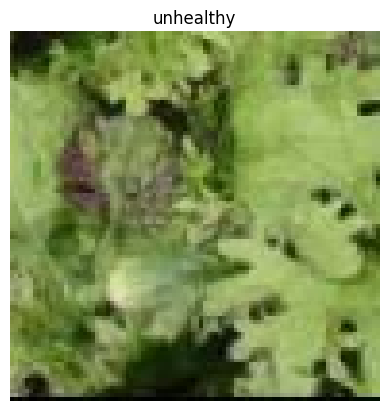

In [2]:
from function_folder.import_data_and_viusalization import file_upload
npzobj = file_upload()

X = npzobj['data']  # X is a np array that contains images
y = npzobj['labels'] # Y is a np array that contains labels

### Splitting the dataset

In [3]:
import function_folder.splitter as split
X_train, X_val,X_test, y_train, y_val,y_test = split.splitting_function(X,y)
#importlib.reload(split)

X_train shape: (5080, 96, 96, 3), y_train shape: (5080, 2)
X_val shape: (60, 96, 96, 3), y_val shape: (60, 2)
X_test shape: (60, 96, 96, 3), y_test shape: (60, 2)


## Model

In [7]:
import function_folder.models.model0 as mod0

importlib.reload(mod0)
mobile = mod0.MobileNetV2()

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

9406464/9406464 [==============================] - 0s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(224, 224, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Data Augmentation

In [9]:
train_generator = ImageDataGenerator(rescale = 1./255)
train_generator = train_generator.flow(
        x=npzobj['data'],
        y=npzobj['labels'],
        batch_size=20,
        shuffle=True,
        sample_weight=None,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        save_format='png',
        ignore_class_split=False,
        subset=None
    )


    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)

In [ ]:
preprocessing = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal"),
  tfkl.RandomTranslation(0.2,0.2),
  tfkl.RandomRotation(0.2),
  tfkl.RandomZoom(0.2),
  tfkl.RandomBrightness(0.5, value_range=(0,1)),
  tfkl.RandomContrast(0.75),
], name='preprocessing')




### Train the model

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

### Plotting

In [ ]:
from function_folder.plotting.history_plot import plot_history

plot_history(tl_history)

## Save the model

In [ ]:
# Save the best model
tl_model.save('Model_0')
del tl_model

## Fine Tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_224').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)


# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()


# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

## Plot

In [ ]:
plot_history(ft_history)

### Evaluation on test set

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)